In [28]:
import pandas as pd
import scipy.io
import glob
import numpy as np 
import mne 

from scipy.signal import hilbert, butter, filtfilt
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft
from scipy import signal
from scipy.integrate import simps 
import seaborn as sns

In [2]:
# read the excel files just in case 
patients_256 = pd.read_excel("/Users/elifozkan/Desktop/EEG-Burst-Suppression-Analysis/3-June2022 /Alle_patienten_256Hz.xlsx")
patients_250 = pd.read_excel("/Users/elifozkan/Desktop/EEG-Burst-Suppression-Analysis/3-June2022 /Alle_patienten_250Hz.xlsx")

/Users/elifozkan/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/Users/elifozkan/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [3]:
patients_250 = patients_250.rename(columns = {"Burstsupressie (ja/nee)" : "BS",
                                                "Nummer" : "ID"})
patients_250 = patients_250.dropna(subset = ["ID"])
patients_250 = patients_250.astype({"ID" : int})
patients_250_ids = list(patients_250["ID"])

In [4]:
patients_256 = patients_256.rename(columns = {"Burstsupressie (ja/nee)" : "BS",
                                                "Nummer" : "ID"})
patients_256 = patients_256.dropna(subset = ["ID"])
patients_256 = patients_256.astype({"ID" : int})
patients_256_ids = list(patients_256["ID"])
#patients_df = pd.concat([patients_data, patients_data1])
#patients_df = patients_df.drop(["file code"], axis = 1)

In [5]:
#not_annoted = patients_df[patients_df["BS"].isna()]
#annotated_patients = patients_df[patients_df['BS'].notna()]

In [6]:
patients = glob.glob("/Users/elifozkan/Desktop/EEG-Burst-Suppression-Analysis/3-June2022 /*.mat")
patient_files_250 = []
patient_files_256 = []

for i in range(0,len(patients)): 
    temp = patients[i].replace("/Users/elifozkan/Desktop/EEG-Burst-Suppression-Analysis/3-June2022 /patient_","")
    temp = int(temp.replace(".mat", ""))
    if temp in patients_250_ids:
        patient_files_250.append(patients[i])
    else:
        patient_files_256.append(patients[i])
    

In [7]:
# necessary information taken from the data in order to create MNE objects. 
channelLabels = ["Fp1", "Fp2", "F7", "F3", "Fz", "F4", "F8",
                "A1", "T3", "C3", "Cz", "C4", "T4", "A2", "T5", 
                "P3", "Pz", "P4", 'T6', '01', '02', 'ECG']
trials = 1 
n_channels = 22
ch_types = ['eeg'] * (n_channels-3)
ch_types.append('misc')
ch_types.append('misc')
ch_types.append('ecg')

In [8]:
def define_montage(type):
    '''method that helps us define the channel locations '''

    # Form the 10-20 montage 'standard_1020'
    mont1020 = mne.channels.make_standard_montage(type)
    # Choose what channels you want to keep 
    # Make sure that these channels exist e.g. T1 does not exist in the standard 10-20 EEG system!
    kept_channels = ["Fp1", "Fp2", "F7", "F3", "Fz", "F4", "F8",
                "A1", "T3", "C3", "Cz", "C4", "T4", "A2", "T5", 
                "P3", "Pz", "P4", 'T6']
    ind = [i for (i, channel) in enumerate(mont1020.ch_names) if channel in kept_channels]
    mont1020_new = mont1020.copy()
    # Keep only the desired channels
    mont1020_new.ch_names = [mont1020.ch_names[x] for x in ind]
    kept_channel_info = [mont1020.dig[x+3] for x in ind]
    # Keep the first three rows as they are the fiducial points information
    mont1020_new.dig = mont1020.dig[0:3]+kept_channel_info
    
    #mont1020.plot()
    #mont1020_new.plot()
    
    return mont1020_new

In [9]:
def create_MNE_objects(patient_list,channelLabels,n_channels,sampling_frequency,phase,types): 
    evoked_arrays = []
    for i in range(0,len(patient_list)): 
        patient = scipy.io.loadmat(patient_list[i])
        samples = patient[phase]["data"][0][0]
        
        info = mne.create_info(
        ch_names = channelLabels, 
        ch_types = types,
        sfreq = sampling_frequency)
        
        info.set_montage(define_montage('standard_1020'))
        evoked_array = mne.EvokedArray(samples, info,
                               nave=samples.shape[0], comment=('patient' + str(i)))
        evoked_arrays.append(evoked_array)
    return evoked_arrays

In [10]:
def create_Raw_objects(patient_list,channelLabels,n_channels,sampling_frequency,phase,types,ids):
    evoked_arrays = {}
    for i in range(0,len(patient_list)): 
        patient = scipy.io.loadmat(patient_list[i])
        samples = patient[phase]["data"][0][0]
        
        info = mne.create_info(
        ch_names = channelLabels, 
        ch_types = types,
        sfreq = sampling_frequency)
        
        info.set_montage(define_montage('standard_1020'))
        evoked_array = mne.io.RawArray(samples, info)
        evoked_arrays.update({ids[i] : evoked_array })
    return evoked_arrays

In [11]:
eeg_InDia_250 = create_Raw_objects(patient_files_250, channelLabels, n_channels, 250,"EEG_INDIA",ch_types,patients_250_ids)
eeg_InDia_256 = create_Raw_objects(patient_files_256,channelLabels, n_channels, 256, "EEG_INDIA", ch_types,patients_256_ids)
#eeg_PreOK = create_MNE_objects(patients, channelLabels, n_channels, sampling_frequency, "EEG_PreOK",ch_types)
#eeg_Klem = create_MNE_objects(patients, channelLabels, n_channels, sampling_frequency, "EEG_Klem",ch_types)

Creating RawArray with float64 data, n_channels=22, n_times=0
    Range : 0 ... -1 =      0.000 ...    -0.004 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=391128
    Range : 0 ... 391127 =      0.000 ...  1564.508 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=169409
    Range : 0 ... 169408 =      0.000 ...   677.632 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=291251
    Range : 0 ... 291250 =      0.000 ...  1165.000 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=162501
    Range : 0 ... 162500 =      0.000 ...   650.000 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=152051
    Range : 0 ... 152050 =      0.000 ...   608.200 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=369993
    Range : 0 ... 369992 =      0.000 ...  1479.968 secs
Ready.
Creating RawArray with float64 data, n_channels=22, n_times=501
    Range : 0 ... 500 =     

In [12]:
#remove the signal data where the n_times == 0 
def remove_zero_times(raw_array,patient_ids) : 
    res = raw_array.copy() 
    for i in raw_array: 
        if raw_array[i].n_times == 0 or raw_array[i].n_times == 1:
            del res[i]
            patient_ids.remove(i)
    
    return res,patient_ids

In [13]:
eeg_india_250, patients_250_ids= remove_zero_times(eeg_InDia_250,patients_250_ids)
eeg_india_256, patients_256_ids = remove_zero_times(eeg_InDia_256,patients_256_ids)


In [14]:
eeg_india = {}
eeg_india.update(eeg_india_250)
eeg_india.update(eeg_india_256)


## Time Domain Features 

In [15]:
## extract time-domain features 

def calculate_mean(raw_array, patient_ids):
    mean_dict = {}
    for i in patient_ids: 

        col_mean = raw_array[i].get_data().mean(axis = 1)
        mean = col_mean.mean()

        mean_dict.update({i : mean})
    return mean_dict


def standard_deviation(raw_array, patient_ids): 
    std_dict = {}
    for i in patient_ids: 

        col_std = raw_array[i].get_data().std(axis = 1)
        std = col_std.std()

        std_dict.update({i : std})
    return std_dict





## Frequency Domain Transformation and Features

In [15]:

def calculate_psd(raw_array,fmin, fmax) : 
    psd_arr = []
    freq_arr = []
    for  i in raw_array: 
        print(i)
        spectrum = raw_array[i].compute_psd(method= "welch", fmin = fmin, fmax = fmax)
        psd,freq = spectrum.get_data(return_freqs = True)
    return psd,freq


 -  delta (0.5–4 Hz)
  - theta (4–8 Hz)  
 -  alpha (8–12 Hz)
 -  beta (12–30 Hz)
 -  gamma (30–100 Hz)

In [16]:
## find the different power bands 
psd_delta,freq_delta = calculate_psd(eeg_india, 0.5, 3)
psd_theta, freq_theta = calculate_psd(eeg_india,4,7)
psd_alpha,freq_alpha = calculate_psd(eeg_india, 8,11)
psd_beta,freq_beta = calculate_psd(eeg_india,12,29)
psd_gamma, freq_gamma = calculate_psd(eeg_india,30,100)


2
Effective window size : 1.024 (s)
3
Effective window size : 1.024 (s)
4
Effective window size : 1.024 (s)
5
Effective window size : 1.024 (s)
6
Effective window size : 1.024 (s)
7
Effective window size : 1.024 (s)
8
Effective window size : 1.024 (s)
9
Effective window size : 1.024 (s)
10
Effective window size : 1.024 (s)
11
Effective window size : 1.024 (s)
12
Effective window size : 1.024 (s)
14
Effective window size : 1.024 (s)
15
Effective window size : 1.024 (s)
16
Effective window size : 1.024 (s)
19
Effective window size : 1.024 (s)
20
Effective window size : 1.024 (s)
21
Effective window size : 1.024 (s)
22
Effective window size : 1.024 (s)
23
Effective window size : 1.024 (s)
24
Effective window size : 1.024 (s)
25
Effective window size : 1.024 (s)
27
Effective window size : 1.024 (s)
28
Effective window size : 1.024 (s)
29
Effective window size : 1.024 (s)
30
Effective window size : 1.024 (s)
34
Effective window size : 1.024 (s)
36
Effective window size : 1.024 (s)
37
Effect

In [29]:
def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.
        Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)
    # Frequency resolution
    freq_res = freqs[1] - freqs[0]
    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

def average_band_power(band, eeg_array,relative = False):
    mean_bps = []
    for i in eeg_array: 
        bps = []
        for j in range(0,22): 
            bp = bandpower(eeg_array[i].get_data()[j],250, band,relative)
            bps.append(bp) 
        mean  = np.mean(bps)
        mean_bps.append(mean)
    return mean_bps


In [19]:
mean_power_delta = average_band_power([0.5,3],eeg_india)
mean_power_theta = average_band_power([4,7],eeg_india)
mean_power_alpha = average_band_power([8,11],eeg_india)
mean_power_beta = average_band_power([12,29],eeg_india)
mean_power_gamma = average_band_power([30,50],eeg_india)

/Users/elifozkan/opt/anaconda3/lib/python3.9/site-packages/scipy/signal/spectral.py:1964: UserWarning: nperseg = 1000 is greater than input length  = 501, using nperseg = 501
  warnings.warn('nperseg = {0:d} is greater than input length '


In [24]:
mean_rel_power_delta = average_band_power([0.5,3],eeg_india,relative = True)
mean_rel_power_theta = average_band_power([4,7],eeg_india,relative = True)
mean_rel_power_alpha = average_band_power([8,11],eeg_india,relative = True)
mean_rel_power_beta = average_band_power([12,29],eeg_india,relative = True)
mean_rel_power_gamma = average_band_power([30,50],eeg_india,relative = True)

In [27]:
ids = patients_250_ids+ patients_256_ids
power_df = pd.DataFrame({"ID" : ids, 
                        "mean_alpha" : mean_power_alpha,
                        "mean_beta" : mean_power_beta, 
                        "mean_delta" : mean_power_delta, 
                        "mean_theta" : mean_power_theta, 
                        "mean_gamma" : mean_power_gamma,
                        "mean_rel_alpha" : mean_rel_power_alpha, 
                        "mean_rel_power_beta" : mean_rel_power_beta, 
                        "mean_rel_delta" : mean_rel_power_delta, 
                        "mean_rel_theta" : mean_rel_power_theta, 
                        "mean_rel_gamma" : mean_rel_power_gamma})
power_df



,ID,mean_alpha,mean_beta,mean_delta,mean_theta,mean_gamma,mean_rel_alpha,mean_rel_power_beta,mean_rel_delta,mean_rel_theta,mean_rel_gamma
0,2,0.0,1292.699851,14320.790485,1811.845881,399.281631,767.147305,1326.054316,7785.271579,1834.314635,344.093910
1,3,0.0,122.943896,296.249773,70.302222,22.857952,83.967341,124.824102,184.354878,97.625187,7.604598
2,4,0.0,235.903031,3346.703460,385.196148,43.247458,150.563079,221.165082,1764.370431,432.864111,17.988649
3,5,0.0,171.162377,694.557521,258.513165,30.271494,139.010295,154.616167,424.087968,376.541880,9.857413
4,6,0.0,1205.019568,7690.848703,2152.795622,289.885583,916.795834,1109.780411,5334.156131,2592.210671,207.666316
...,...,...,...,...,...,...,...,...,...,...,...
243,373,0.0,260.168209,1447.762313,272.705692,55.955182,164.785396,264.411669,814.487399,341.559641,23.462942
244,375,0.0,189.713090,615.246168,104.077829,48.894502,72.678851,220.187353,346.483084,107.442800,25.023338
245,376,0.0,67342.841714,13421.655833,11754.736498,49273.486125,17403.831142,93245.931746,11282.918762,17806.564433,68224.241666
246,377,0.0,79.663277,354.807163,121.887879,13.041527,60.087918,71.741786,305.062435,160.005117,4.201576


In [65]:
def plot_spectrum_methods(data, sf, window_sec, band=None, dB=False):

    from mne.time_frequency import psd_array_multitaper
    from scipy.signal import welch, periodogram
    import matplotlib.pyplot as plt
    sns.set(style="white", font_scale=1.2)
    # Compute the PSD
    freqs, psd = periodogram(data, sf)
    freqs_welch, psd_welch = welch(data, sf, nperseg=window_sec*sf)
    psd_mt, freqs_mt = psd_array_multitaper(data, sf, adaptive=True,
                                            normalization='full', verbose=0)
    sharey = False

    # Optional: convert power to decibels (dB = 10 * log10(power))
    if dB:
        psd = 10 * np.log10(psd)
        psd_welch = 10 * np.log10(psd_welch)
        psd_mt = 10 * np.log10(psd_mt)
        sharey = True

    # Start plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=sharey)
    # Stem
    sc = 'slategrey'
    ax2.stem(freqs, psd, linefmt=sc, basefmt=" ", markerfmt=" ")
    ax1.stem(freqs_welch, psd_welch, linefmt=sc, basefmt=" ", markerfmt=" ")
    ax3.stem(freqs_mt, psd_mt, linefmt=sc, basefmt=" ", markerfmt=" ")
    # Line
    lc, lw = 'k', 2
    ax2.plot(freqs, psd, lw=lw, color=lc)
    ax1.plot(freqs_welch, psd_welch, lw=lw, color=lc)
    ax3.plot(freqs_mt, psd_mt, lw=lw, color=lc)
    # Labels and axes
    ax1.set_xlabel('Frequency (Hz)')
    if not dB:
        ax1.set_ylabel('Power spectral density (V^2/Hz)')
    else:
        ax1.set_ylabel('Decibels (dB / Hz)')
    ax2.set_title('Periodogram')
    ax1.set_title('Mean-power Beta Band')
    ax3.set_title('Multitaper')
    if band is not None:
        ax1.set_xlim(band)
    ax1.set_ylim(ymin=0)
    ax2.set_ylim(ymin=0)
    ax3.set_ylim(ymin=0)
    sns.despine()



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/elifozkan/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py:262: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished


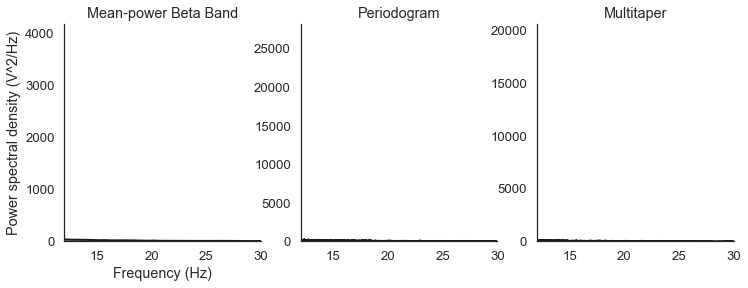

In [66]:
plot_spectrum_methods(eeg_india[2].get_data()[2], 250, 4, band=[12,30], dB=False)